# Prediction of Diabetes Claims

### Abstract

The objective is to test the feasibility of using data collected from DR, IP and OP claims for building models for predicting diabetes. Using the demographic and diagnosis codes of over 50 thousand continuously enrolled patients from the year 2014 to 2015, different ensemble methods were applied to predict the likelihood of developing diabetes by year 2016. An AUC of 79% was achieved using a 100-tree random forest with a prediction accuracy of 94%. Forecasting diabetes diagnosis can potentially allow the automated identification of high-risk populations and possible prevention of further development of diabetes through pre-emptive adjustments in lifestyle such as a healthy diet and regular exercise. The study shows that predicting diabetes using machine learning is feasible.

### Diabetes Milletus

Diabetes Mellitus, more commonly known as Diabetes, is a disease in which the body is no longer able to carefully control the blood glucose levels.  Increased blood glucose levels (hyperglycemia) can cause damage to the body’s tissues, including the nerves, blood vessels, and tissues in the eyes. [1] Data from 2014 reveals that Diabetes is the 7th highest cause of death in the US. [2]

##### Three Types of Diabetes  
 
Type 1 Diabetes – also called insulin dependent diabetes mellitus, is an autoimmune condition where the body’s immune system misidentifies the insulin-producing cells in the pancreas and attacks these cells. [3]  
 
Type 2 Diabetes – also called non-insulin dependent diabetes mellitus, is attributed to the resistance of the body to insulin because of chronic high blood glucose levels.  
 
Gestational Diabetes – a form of glucose intolerance diagnosed in some women during pregnancy. [4]  


### Problem Statement

We want to see if its possible to predict, using machine learning techniques, the possible diagnosis of diabetes of a patient in the next year given his/her insurance claims data from the past 2 years.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from IPython.display import Image

### Building the Dataset

The full database is in pdb_IMPACT. It containts the tables we need to construct the dataset:  

##### Tables
1. Commercial IP Claims
2. Commercial DR Claims
3. Commercial OP Claims
4. Commercial Members
5. Diagnosis Crosswalk

The first 4 contains data from commercial insurance claims. For this dataset, we use only the fields like demographics (age, gender), insurance allowable amount, service date (year, month, day), and the first diagnosis (diagnosis code). We take only the members that are continuously enrolled from 2014 to 2016 which results to around 50k unique patients.  

#### Prepping the Data for Machine Learning

For this research, we will be building a binary classification model. To construct the input, we take the claims data from 2014 to 2015 of patients who have been diagnosed with diabetes in 2016. These will have a y-value (output) of 1. Conversely, those who have no diagnosis of diabetes from 2014 through to 2016 will have a y-value of 0. Around 3% of the data is diabetic and the rest (97%) is non-diabetic which gives us an extremely imbalanced dataset. The details of pre-processing the tables is in the notebook *FULL_IMPACT*.

#### Diagnosis Codes and AHRQ Codes

The main feature used in creating the dataset is the AHRQ (Agency for Healthcare Research and Quality) codes which was based on the first diagnosis code (Diag_CD_1) of each claim.  We initially thought of using the ICD-10 codes as our feature sets but it contained around 25000+ unique codes so it is not advisable to do one-hot-encoding on it.  This led us to the AHRQ codes which aggregates diagnosis codes into more general disease codes.  This resulted to around 300+ AHRQ codes of which ‘49’ is labelled as a diabetes mellitus diagnosis.

#### Load Data

The input dataframe was pickled and re-loaded below.

In [10]:
X = pd.read_pickle('X_diab.pkl')

In [12]:
no = 2890010 #no diabetes
di = 90376 #with diabetes
y = np.concatenate([np.array([0]*no), np.array([1]*di)])

#### Sample Claims Data

The 2-data-point dataframe below shows a sample of the input claims data which shows the allowable amount, age, AHRQ codes in one-hot representation, the source claims (DR, IP, OP), and the Gender (is_Diab is dropped through the pipeline. Although it doesn't matter since is_Diab is false for all $X$ regardless of $y$).

In [13]:
X.head(2)

,Allw_Amt,Age,1,2,3,4,5,6,7,8,...,2609,2610,2611,2617,9999,DR,IP,OP,is_Diab,Gdr
0,3.35,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True
1,102.09,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True


### Visualizing the Data

#### Age Distribution

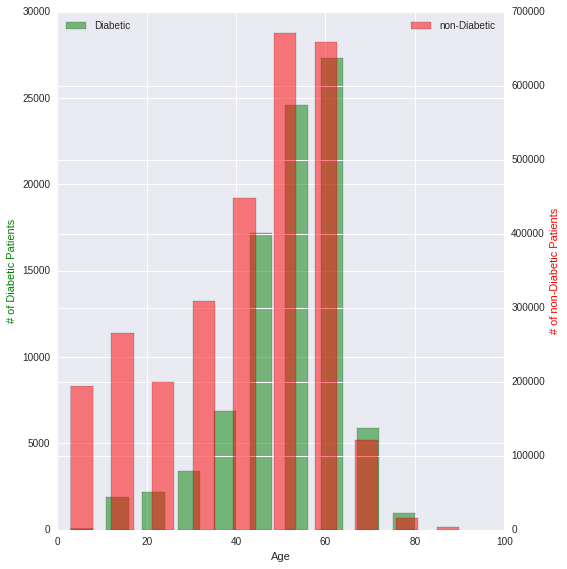

In [15]:

fig, ax1 = plt.subplots(figsize = (8,8))
ax1.hist(X[y == 1]['Age'].as_matrix().astype(float), alpha = 0.5, label = 'Diabetic', color = 'g', width = 5)

ax1.set_ylabel('# of Diabetic Patients', color='g')
ax1.set_xlabel('Age')
ax1.legend(loc  =2)
ax2 = ax1.twinx()
ax2.hist(X[y == 0]['Age'].as_matrix().astype(float), alpha = 0.5, label = 'non-Diabetic', color='r', width = 5)
ax2.set_ylabel('# of non-Diabetic Patients', color='r')
# ax2.set_ylim(0, 1)
ax2.set_xlabel('Age')
fig.tight_layout()
ax2.legend(loc = 1)
plt.show()

The plot above is a 2-axis histogram of age for both the diabetic and non-diabetic groups. We split the visual into 2 axes since there's around 33 times more non-diabetic claims datapoints than diabetic. We see that the non-diabetic group has more datapoints in the younger range as compared to its mode than the diabetic group.  

#### Gender Distribution

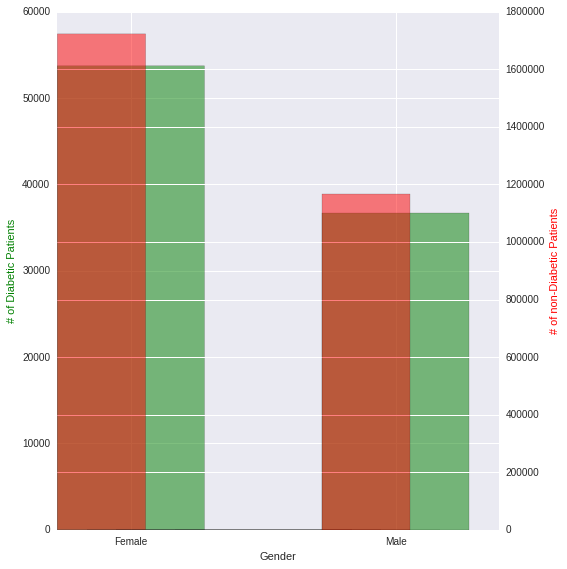

In [18]:

fig, ax1 = plt.subplots(figsize = (8,8))
ax1.hist(X[y == 1]['Gdr'].as_matrix().astype(int), alpha = 0.5, label = 'Diabetic', color = 'g', width = .5)
ax1.set_xticks([0.25, 1.15])

ax1.set_ylabel('# of Diabetic Patients', color='g')
ax1.set_xlabel('Gender')

ax1.set_xlim(0, 1.5)
ax1.set_xticklabels(['Female', 'Male'])
ax2 = ax1.twinx()
ax2.hist(X[y == 0]['Gdr'].as_matrix().astype(int), alpha = 0.5, label = 'non-Diabetic', color='r', width = .3)
ax2.set_ylabel('# of non-Diabetic Patients', color='r')

ax2.set_xlabel('Gender')
ax2.set_xlim(0, 1.5)
ax2.set_xticklabels(['Female', 'Male'])
fig.tight_layout()

plt.show()

### Training the Data

We split the dataset into train-test 60%-40%. To fix the imbalance, we use Synthetic Minority Over-Sampling Technique (SMOTE) on the training data. 

#### Models Used

We used different methods such as logistic regression, random forest, decision trees, XG Boost classifiers, etc. Random forest with 100 trees was the best classifier with 79.3% AUC of the ROC curve with 94% prediction accuracy.

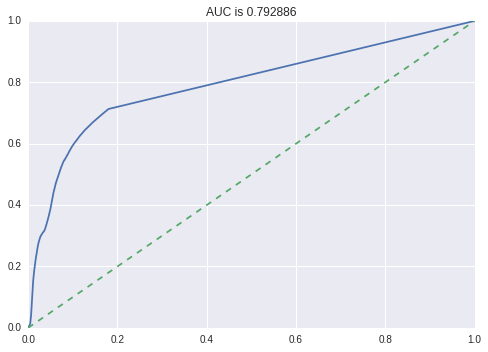

In [24]:
Image('ROC_RF_100_X.png')

The figure above is the ROC curve of the ramdom forest model trained on tha dataset. the x-axis is the false positive rate and the y-axis is the true positive rate. The more the curve tends to go up and to the right, the better the model. The green diagonal line shows the result when a model performs at its worst.

### Feature Importance

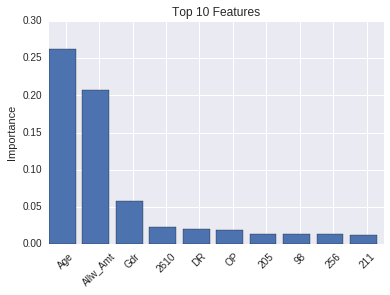

In [25]:
Image('feat_10.png')

Using the feature importance module of the random forest, the plot above shows the top 10 most important features of model:  
1. Age (int)
2. Allowable Amount (float)
3. Gender (boolean)
4. Transport; not MVT (boolean)
5. DR claim (boolean)
6. OP claim (boolean)
7. Spondylosis; intervertebral disc disorders; other back problems
8. Essential Hypertension
9. Medical examination/evaluation
10. Other connective tissue disease

### Dimensionality Reduction

Using principal component analysis (PCA), we reduce the number of features from 300+ to 10, 20 and 30 and observe the corresponding ROC curves, AUCs and accuracies. We also compare the results to using just the top 50 important features, just the AHRQ onehot features and just the demographics as inputs to the model.

In [31]:
pd.read_pickle('acc_auc.pkl')

,Accuracy,AUC
X,0.940408,0.790451
X_pca_10,0.938742,0.784960
X_pca_20,0.937558,0.788886
X_pca_30,0.936822,0.789591
X_feats_50,0.922305,0.752309
X_demog,0.857654,0.712812
X_AHRQ,0.583232,0.650922


The dataframe above shows the result of using specific sets of features as inputs to a 100-tree random forest classifier. $X$, the full-featured input, performed the best while a close second is the same $X$ reduced, through PCA, to 10 dimensions or features of greatest variance.

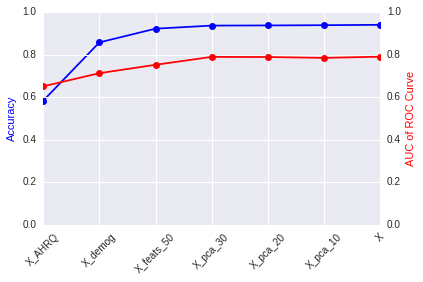

In [32]:
Image('acc_auc_feat.png')

It can be seen from the graph above that reducing the dimensions of the input $X$ doesn't have a significant effect the resulting accuracy and AUC. Using just the AHRQ onehot features performed the worst followed by using just the demographics. From this, we can perform much faster runs since we can now use just 10 dimensions instead of 300+.

### Conclusion

We have shown the feasibility of using machine learning and health insurance claims data from the previous 2 years to predict the diagnosis of diabetes in the following year. We obtained a prediction accuracy of 94% with AUC at 79% using a 100-tree random forest. We have also shown that reduction of the number of features through PCA doesn't significantly reduce the accuracy and AUC of the model resulting in faster training times and lesser memory allocations.